In [55]:
import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support,classification_report,roc_curve, auc
import time
import matplotlib.pyplot as plt

In [39]:
data_path = "C:/Users/lay89/OneDrive/文件/碩班/113-1機器學習/期末報告/archive/cardio_train.csv"
df = pl.read_csv(data_path,separator=";")

In [56]:
rows, cols = df.shape
print(f"Rows: {rows}, Columns: {cols}")
print(df.head(20))
print(df.describe())
print(df.columns)
#70000筆 12個變數

Rows: 70000, Columns: 13
shape: (20, 13)
┌─────┬───────┬────────┬────────┬───┬───────┬──────┬────────┬────────┐
│ id  ┆ age   ┆ gender ┆ height ┆ … ┆ smoke ┆ alco ┆ active ┆ cardio │
│ --- ┆ ---   ┆ ---    ┆ ---    ┆   ┆ ---   ┆ ---  ┆ ---    ┆ ---    │
│ i64 ┆ i64   ┆ i64    ┆ i64    ┆   ┆ i64   ┆ i64  ┆ i64    ┆ i64    │
╞═════╪═══════╪════════╪════════╪═══╪═══════╪══════╪════════╪════════╡
│ 0   ┆ 18393 ┆ 2      ┆ 168    ┆ … ┆ 0     ┆ 0    ┆ 1      ┆ 0      │
│ 1   ┆ 20228 ┆ 1      ┆ 156    ┆ … ┆ 0     ┆ 0    ┆ 1      ┆ 1      │
│ 2   ┆ 18857 ┆ 1      ┆ 165    ┆ … ┆ 0     ┆ 0    ┆ 0      ┆ 1      │
│ 3   ┆ 17623 ┆ 2      ┆ 169    ┆ … ┆ 0     ┆ 0    ┆ 1      ┆ 1      │
│ 4   ┆ 17474 ┆ 1      ┆ 156    ┆ … ┆ 0     ┆ 0    ┆ 0      ┆ 0      │
│ …   ┆ …     ┆ …      ┆ …      ┆ … ┆ …     ┆ …    ┆ …      ┆ …      │
│ 24  ┆ 16782 ┆ 2      ┆ 172    ┆ … ┆ 0     ┆ 0    ┆ 0      ┆ 1      │
│ 25  ┆ 21296 ┆ 1      ┆ 170    ┆ … ┆ 0     ┆ 0    ┆ 0      ┆ 0      │
│ 27  ┆ 16747 ┆ 1      ┆ 158    ┆ … 

In [57]:
#missing
missing_count = df.null_count()
missing_ratio = missing_count / df.shape[0] * 100
print("每列缺失值比例 (%)：")
print(missing_ratio)
# 將每列缺失值數量轉換為字典
missing_count_dict = {col: missing_count[col][0] for col in missing_count.columns}

# 篩選出有缺失值的列及其缺失值數量
columns_with_missing = {col: count for col, count in missing_count_dict.items() if count > 0}

# 打印結果
print("每列缺失值數量：")
print(missing_count_dict)

print("包含缺失值的列及數量：")
print(columns_with_missing)

#沒有缺失值

每列缺失值比例 (%)：
shape: (1, 13)
┌─────┬─────┬────────┬────────┬───┬───────┬──────┬────────┬────────┐
│ id  ┆ age ┆ gender ┆ height ┆ … ┆ smoke ┆ alco ┆ active ┆ cardio │
│ --- ┆ --- ┆ ---    ┆ ---    ┆   ┆ ---   ┆ ---  ┆ ---    ┆ ---    │
│ f64 ┆ f64 ┆ f64    ┆ f64    ┆   ┆ f64   ┆ f64  ┆ f64    ┆ f64    │
╞═════╪═════╪════════╪════════╪═══╪═══════╪══════╪════════╪════════╡
│ 0.0 ┆ 0.0 ┆ 0.0    ┆ 0.0    ┆ … ┆ 0.0   ┆ 0.0  ┆ 0.0    ┆ 0.0    │
└─────┴─────┴────────┴────────┴───┴───────┴──────┴────────┴────────┘
每列缺失值數量：
{'id': 0, 'age': 0, 'gender': 0, 'height': 0, 'weight': 0, 'ap_hi': 0, 'ap_lo': 0, 'cholesterol': 0, 'gluc': 0, 'smoke': 0, 'alco': 0, 'active': 0, 'cardio': 0}
包含缺失值的列及數量：
{}


In [58]:
# 計算每個值的頻率和比例
binary_table = (
    df.group_by("cardio")
    .agg([
        pl.col("cardio").count().alias("count"),
    ])
    .with_columns((pl.col("count") / df.shape[0] * 100).alias("percentage"))
)

# 顯示結果
print(binary_table)

shape: (2, 3)
┌────────┬───────┬────────────┐
│ cardio ┆ count ┆ percentage │
│ ---    ┆ ---   ┆ ---        │
│ i64    ┆ u32   ┆ f64        │
╞════════╪═══════╪════════════╡
│ 0      ┆ 35021 ┆ 50.03      │
│ 1      ┆ 34979 ┆ 49.97      │
└────────┴───────┴────────────┘


In [59]:
# 2. 建立不平衡資料集 (cardio 0:1 = 10:1)
#    2.1 分開 0 與 1 兩群
df_0 = df.filter(pl.col("cardio") == 0)
df_1 = df.filter(pl.col("cardio") == 1)

#    2.2 計算所需樣本數 (假設想要 negative : positive = 10:1)
count_0 = df_0.shape[0]  # 負樣本數量
target_1 = 0.1 * count_0  # 需要的正樣本數量

#    2.3 若 df_0 的數量足夠，隨機抽取 target_0 筆
#        若 df_0 不足，可自行決定是全部取完或調整策略
df_1_sample = df_1.sample(n=target_1, shuffle=True, seed=42)  # polars 的隨機抽樣

#    2.4 合併負樣本 (0) 與正樣本 (1)
df_unbalanced = pl.concat([df_1_sample, df_0], how="vertical")

#    2.5 打亂資料 (避免原本順序造成偏差)
df_unbalanced = df_unbalanced.sample(
    n=df_unbalanced.shape[0],  # 整個 DataFrame 的總筆數
    shuffle=True, 
    seed=123
)
print(f"新資料集大小: {df_unbalanced.shape}")
count_0_new = df_unbalanced.filter(pl.col("cardio") == 0).shape[0]
count_1_new = df_unbalanced.filter(pl.col("cardio") == 1).shape[0]
print(f"cardio=0 : cardio=1 = {count_0_new}:{count_1_new} (約 {count_0_new/count_1_new:.1f}:1)")


新資料集大小: (38523, 13)
cardio=0 : cardio=1 = 35021:3502 (約 10.0:1)


In [60]:
train_df, test_df = train_test_split(df_unbalanced.to_pandas(),
                                     test_size=1/6, 
                                     random_state=2023,
                                     shuffle=True)

In [61]:
# 4. 準備特徵與標籤
#    假設要丟進模型的欄位是除了 'id' 和 'cardio' 之外的所有欄位
features = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 
            'cholesterol', 'gluc', 'smoke', 'alco', 'active']

X_train = train_df[features]
y_train = train_df['cardio']
X_test = test_df[features]
y_test = test_df['cardio']

In [62]:
# =========================
# (A) 一般 XGBoost 模型
# =========================
print("=== (A) 一般 XGBoost 模型 ===")
start_time = time.time()
model_normal = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                 random_state=42)
model_normal.fit(X_train, y_train)

y_pred_normal = model_normal.predict(X_test)
cm_normal = confusion_matrix(y_test, y_pred_normal)
print("Confusion Matrix:\n", cm_normal)
print("Classification Report:\n", classification_report(y_test, y_pred_normal))
end_time = time.time()
execution_time = end_time - start_time
print(f"執行時間: {execution_time:.4f} 秒")


=== (A) 一般 XGBoost 模型 ===
Confusion Matrix:
 [[5762   95]
 [ 512   52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      5857
           1       0.35      0.09      0.15       564

    accuracy                           0.91      6421
   macro avg       0.64      0.54      0.55      6421
weighted avg       0.87      0.91      0.88      6421

執行時間: 0.1536 秒


c:\Users\lay89\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [15:08:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# =========================
# (B) 使用scale_pos_weight 的 XGBoost
#     對「cardio=1」給予較高權重
# =========================
print("=== (B) 使用 scale_pos_weight 的 XGBoost ===")
# 設定 scale_pos_weight = 10, 代表正樣本的重要性是負樣本的 10 倍
start_time = time.time()
model_weighted = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                   scale_pos_weight=10,  # 核心參數
                                   random_state=42)
model_weighted.fit(X_train, y_train)

y_pred_weighted = model_weighted.predict(X_test)
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
print("Confusion Matrix (Weighted):\n", cm_weighted)
print("Classification Report (Weighted):\n", classification_report(y_test, y_pred_weighted))
end_time = time.time()
execution_time = end_time - start_time
print(f"執行時間: {execution_time:.4f} 秒")

=== (B) 使用 scale_pos_weight 的 XGBoost ===
Confusion Matrix (Weighted):
 [[4900  957]
 [ 258  306]]
Classification Report (Weighted):
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      5857
           1       0.24      0.54      0.33       564

    accuracy                           0.81      6421
   macro avg       0.60      0.69      0.61      6421
weighted avg       0.89      0.81      0.84      6421

執行時間: 0.1586 秒


c:\Users\lay89\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [17:12:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [83]:
# =========================
# (C) 分層篩選
# =========================

# === 第一階段模型：Logistic Regression ===
print("=== (D) 使用Logistic regression做一階分類，再使用XGBoost進行二階分類 ===")
# 設置低閾值，抓取高風險樣本
print("=== 第一階段篩選 ===")
start_time = time.time()
logistic_model = LogisticRegression(random_state=42,class_weight={0:1, 1:10})
logistic_model.fit(X_train, y_train)

# 預測機率並標記高風險樣本
y_pred_probs_stage1 = logistic_model.predict_proba(X_test)[:, 1]  # 預測機率 (Positive)
low_threshold = 0.3  # 第一階段的寬鬆閾值
stage1_high_risk = (y_pred_probs_stage1 > low_threshold).astype(int)  # 標記高風險樣本

# 查看第一階段的效果
print("第一階段高風險樣本比例:", stage1_high_risk.mean())
print("第一階段混淆矩陣:\n", confusion_matrix(y_test, stage1_high_risk))
print("第一階段分類報告:\n", classification_report(y_test, stage1_high_risk))

# 第一階段篩選高風險樣本 (測試集)
print("=== 第二階段篩選 ===")

# 確保索引對齊 (只篩選測試集中的高風險樣本)
high_risk_indices_test = (stage1_high_risk == 1)  # 高風險樣本索引 (測試集)
X_test_high_risk = X_test[high_risk_indices_test]
y_test_high_risk = y_test[high_risk_indices_test]

# 若需要對訓練集進行分層篩選（可選）
y_pred_probs_stage1_train = logistic_model.predict_proba(X_train)[:, 1]
high_risk_indices_train = (y_pred_probs_stage1_train > low_threshold)  # 高風險樣本索引 (訓練集)
X_train_high_risk = X_train[high_risk_indices_train]
y_train_high_risk = y_train[high_risk_indices_train]

# 第二階段模型：XGBoost (僅對高風險樣本進行訓練與預測)

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "scale_pos_weight":10,
    "max_depth": 5,
    "eta": 0.1,
    "seed": 42
}
dtrain_high_risk = xgb.DMatrix(X_train_high_risk, label=y_train_high_risk)
dtest_high_risk = xgb.DMatrix(X_test_high_risk, label=y_test_high_risk)

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_high_risk,
    num_boost_round=100,
    evals=[(dtest_high_risk, "test")],
    verbose_eval=False
)

# 預測高風險樣本
y_pred_probs_stage2 = xgb_model.predict(dtest_high_risk)
high_threshold = 0.5  # 第二階段的嚴格閾值
stage2_pred = (y_pred_probs_stage2 > high_threshold).astype(int)

# 查看第二階段的效果
print("第二階段混淆矩陣:\n", confusion_matrix(y_test_high_risk, stage2_pred))
print("第二階段分類報告:\n", classification_report(y_test_high_risk, stage2_pred))

# 整合結果 (將第一階段低風險樣本視為 cardio=0，第二階段的結果覆蓋高風險樣本)
final_predictions = np.zeros_like(y_test)  # 初始化為低風險
final_predictions[high_risk_indices_test] = stage2_pred  # 第二階段結果覆蓋高風險樣本
# 查看整體效果
print("整體混淆矩陣:\n", confusion_matrix(y_test, final_predictions))
print("整體分類報告:\n", classification_report(y_test, final_predictions))
end_time = time.time()
execution_time = end_time - start_time
print(f"執行時間: {execution_time:.4f} 秒")


=== (D) 使用Logistic regression做一階分類，再使用XGBoost進行二階分類 ===
=== 第一階段篩選 ===
第一階段高風險樣本比例: 0.7743342158542283
第一階段混淆矩陣:
 [[1418 4439]
 [  31  533]]
第一階段分類報告:
               precision    recall  f1-score   support

           0       0.98      0.24      0.39      5857
           1       0.11      0.95      0.19       564

    accuracy                           0.30      6421
   macro avg       0.54      0.59      0.29      6421
weighted avg       0.90      0.30      0.37      6421

=== 第二階段篩選 ===
第二階段混淆矩陣:
 [[3324 1115]
 [ 175  358]]
第二階段分類報告:
               precision    recall  f1-score   support

           0       0.95      0.75      0.84      4439
           1       0.24      0.67      0.36       533

    accuracy                           0.74      4972
   macro avg       0.60      0.71      0.60      4972
weighted avg       0.87      0.74      0.79      4972

整體混淆矩陣:
 [[4742 1115]
 [ 206  358]]
整體分類報告:
               precision    recall  f1-score   support

           0       0.96      0

c:\Users\lay89\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


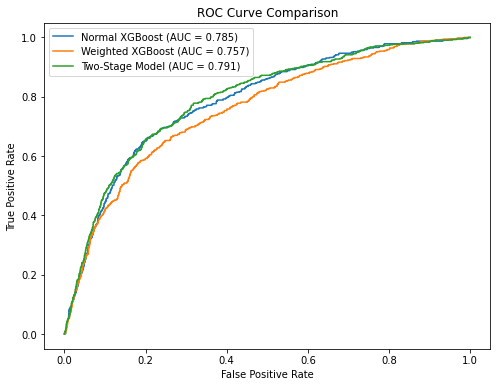

In [82]:
# =========================
# 繪製ROC Curve
# =========================

#一般xg boost 的預測機率
y_prob_normal = model_normal.predict_proba(X_test)[:, 1]
#print(y_prob_normal)

#weighted XGBoost的預測機率
y_prob_weighted = model_weighted.predict_proba(X_test)[:, 1]
#print(y_prob_weighted)

#二階分類的預測機率
dtest = xgb.DMatrix(X_test)
y_prob_logistic = logistic_model.predict_proba(X_test)[:, 1]  # 第一階段機率
high_idx = (y_prob_logistic > 0.2)  # 第一階段篩選「高風險」樣本
low_idx = (y_prob_logistic <= 0.2)
dtest_high = xgb.DMatrix(X_test[high_idx])  # 只取高風險樣本的子集
y_pred_probs_stage2 = xgb_model.predict(dtest_high)  # 第二階段的機率預測
y_prob_2stage = np.zeros_like(y_prob_logistic)
y_prob_2stage[low_idx] = y_prob_logistic[low_idx]
y_prob_2stage[high_idx] = y_pred_probs_stage2

# 一般 XGBoost 的 ROC 曲線
fpr_normal, tpr_normal, _ = roc_curve(y_test, y_prob_normal)
auc_normal = auc(fpr_normal, tpr_normal)

# Weighted XGBoost 的 ROC 曲線
fpr_weighted, tpr_weighted, _ = roc_curve(y_test, y_prob_weighted)
auc_weighted = auc(fpr_weighted, tpr_weighted)

# 二階段模型的 ROC 曲線
fpr_2stage, tpr_2stage, _ = roc_curve(y_test, y_prob_2stage)
auc_2stage = auc(fpr_2stage, tpr_2stage)

# 繪製 ROC 曲線
plt.figure(figsize=(8, 6))
plt.plot(fpr_normal, tpr_normal, label=f"Normal XGBoost (AUC = {auc_normal:.3f})")
plt.plot(fpr_weighted, tpr_weighted, label=f"Weighted XGBoost (AUC = {auc_weighted:.3f})")
plt.plot(fpr_2stage, tpr_2stage, label=f"Two-Stage Model (AUC = {auc_2stage:.3f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="best")
plt.show()
